In [47]:
%reset
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import glob
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/')
import scendict as sc
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/MODPROC_ROBOT/MultiModelMonitor/WORK_SCRIPTS')
import breakdown as bp
import numpy as np

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [48]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [49]:
## extract values into datasets


## PROBLEM 1: TOM12_TJ_1AS6 goes unstable in year 2056, see:


In [50]:

runbd = False
sdir = '/gpfs/home/mep22dku/scratch/SOZONE/MODPROC_ROBOT/MultiModelMonitor/OUTPUT/'
## filename for resulting plot
fnam = 'Cflx_comparison.png'
##models to extract
tms = ['TOM12_TJ_1AS6','TOM12_DW_WE43', 'TOM12_DW_GA01','TOM12_TJ_3AS1']
tms_te = ['TOM12_TJ_3AS1']
cols = [ sc.scen['1A']['color'],'grey', 'b',sc.scen['3A']['color']]


#descriptions
descs = [\
         '1AS6: TJ, Met Office, Hist. ozone, \n SSP 1-2.6, restart from WE43 in 1948',\
         'DW_WE43: Dave, ERA5',\
         'DW_GA01: Dave, GCB run, NCEP',\
        '3AS1: TJ, Met Office, Ozone-1990, \n SSP 1-2.6, restart from WE43 in 1948',]

if runbd:
    for tm in tms_te:
        bp.breakdown_maker(tm, fmi = 1948, resDir = sdir)

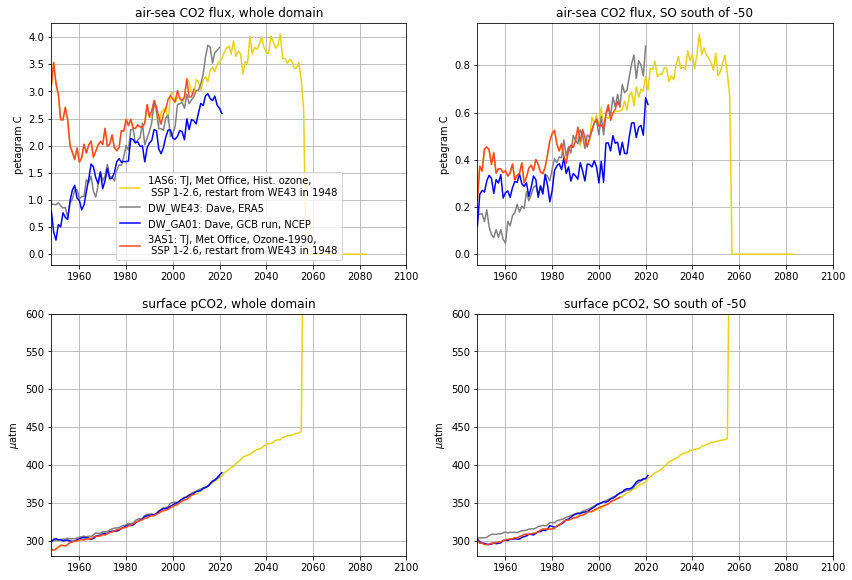

In [51]:
dsets = []

for tm in tms:
    w = glob.glob(f'{sdir}/*cflx*{tm}*')
    
    ds = xr.open_dataset(w[0])
    dsets.append(ds)
    

tend = 2100; tendatm = 600
fact = 0.7
fig, axs = plt.subplots(2,2, figsize=(20*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

### cflx total
for i in range(0,len(dsets)):
    ds = dsets[i]; col = cols[i]
    axs[0].plot(ds.yrs, ds.cflx, color = col, label = descs[i])
    axs[1].plot(ds.yrs, ds.cflx_so, color = col)
    axs[2].plot(ds.yrs, ds.pco2, color = col)
    axs[3].plot(ds.yrs, ds.pco2_so, color = col)

tits = ['air-sea CO2 flux, whole domain', 'air-sea CO2 flux, SO south of -50',\
        'surface pCO2, whole domain', 'surface pCO2, SO south of -50']
ylabs = ['petagram C', 'petagram C', '$\mu$atm', '$\mu$atm']
for i in range(0,4):
    axs[i].grid()
    axs[i].set_xlim(1948,tend)
    axs[i].set_title(tits[i])
    axs[i].set_ylabel(ylabs[i])
    if i >1:
        axs[i].set_ylim([280,tendatm])
        
axs[0].legend()

Text(0.5, 1.0, 'mean area-weighted surface pco2')

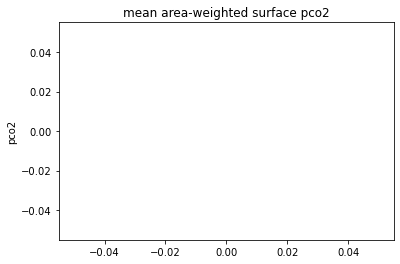

In [52]:
ds = dsets[1] # 1as6
ts = 95
plt.plot(ds['yrs'].values[ts:110], ds['pco2'].values[ts:110])
plt.ylabel('pco2')
plt.title('mean area-weighted surface pco2')

## let's look at some results - reproduce dave's diagnostic - GOC went wonky 20 years earlier

In [53]:
t_yearlist = bp.make_yearlist(2000,2058,'ptrc','TOM12_TJ_1AS6', '/gpfs/afm/greenocean/software/runs')
tds_ptrc = xr.open_mfdataset(t_yearlist)

# t_yearlist = bp.make_yearlist(2056,2058,'grid','TOM12_TJ_1AS6', '/gpfs/afm/greenocean/software/runs')
# tds_grid = xr.open_mfdataset(t_yearlist)

In [ ]:
GOC =tds_ptrc['GOC']

goc_mean = np.zeros([708])
goc_max = np.zeros([708])
for i in range(0,708):
    if i%50 == 0:
        print(i)
    getGOC = tds_ptrc['GOC'][i,:,:,:].values
    getGOC[np.where(getGOC == 0)] = np.nan
    goc_mean[i] = np.nanmean(getGOC)
    goc_max[i] = np.nanmax(getGOC)

0
50
100
150
200
250


In [ ]:
td = tds_ptrc.indexes['time_counter'].to_datetimeindex()

### we see that GOC has gone unstable!

In [ ]:

plt.plot(td,goc_mean, label = 'mean')
plt.plot(td,goc_max, label = 'max')
plt.title('GOC, model mean (not volume weighted)')
plt.legend()
plt.ylabel('mol/L')
plt.yscale('log')

### things like DIC pCO2 or CO2 flux don't explode until way later:

In [ ]:
t_yearlist = bp.make_yearlist(2056,2058,'diad','TOM12_TJ_1AS6', '/gpfs/afm/greenocean/software/runs')
tds_diad = xr.open_mfdataset(t_yearlist)
t_yearlist = bp.make_yearlist(2056,2058,'ptrc','TOM12_TJ_1AS6', '/gpfs/afm/greenocean/software/runs')
tds_ptrc = xr.open_mfdataset(t_yearlist)

In [ ]:
tds = tds_ptrc
tvar = 'DIC'
dates = tds.indexes['time_counter'].to_datetimeindex()
for i in range(8,13):
    ts = 47
    fact = 0.2
    fig, axs = plt.subplots(1,1, figsize=(20*fact, 14*fact), facecolor='w', edgecolor='k')
    atmpco2 = (tds[tvar][i,0,:,:]*1e6)
    w = axs.pcolormesh(atmpco2)
    plt.title(f'surface {tvar}: {dates[i].year}, month {dates[i].month}, \n mean = {np.nanmean(atmpco2.values)}, \n max = {np.nanmax(atmpco2.values)}, \n min = {np.nanmin(atmpco2.values)}')
    plt.colorbar(w)
    plt.show()

In [ ]:
tds = tds_diad
tvar = 'pCO2'
dates = tds.indexes['time_counter'].to_datetimeindex()
for i in range(8,13):
    ts = 47
    fact = 0.2
    fig, axs = plt.subplots(1,1, figsize=(20*fact, 14*fact), facecolor='w', edgecolor='k')
    atmpco2 = (tds[tvar][i,:,:])
    w = axs.pcolormesh(atmpco2)
    plt.title(f'{tvar}: {dates[i].year}, month {dates[i].month}, \n mean = {np.nanmean(atmpco2.values)}, \n max = {np.nanmax(atmpco2.values)}, \n min = {np.nanmin(atmpco2.values)}')
    plt.colorbar(w)
    plt.show()

In [ ]:
tds = tds_diad
tvar = 'Cflx'
dates = tds.indexes['time_counter'].to_datetimeindex()
for i in range(8,13):
    ts = 47
    fact = 0.2
    fig, axs = plt.subplots(1,1, figsize=(20*fact, 14*fact), facecolor='w', edgecolor='k')
    atmpco2 = (tds[tvar][i,:,:])
    w = axs.pcolormesh(atmpco2)
    plt.title(f'{tvar}: {dates[i].year}, month {dates[i].month}, \n mean = {np.nanmean(atmpco2.values)}, \n max = {np.nanmax(atmpco2.values)}, \n min = {np.nanmin(atmpco2.values)}')
    plt.colorbar(w)
    plt.show()

Solution being worked on:

    - set artificial limits for GOC production in bccsed as follows, line 56:
    
    !   where ( trn(:,:,:,jpgoc) > 1E-4 ) trn(:,:,:,jpgoc) = 1E-4
   
/gpfs/home/yzh17dvu/scratch/test_ada_compile/NEMO/nemo_planktom/nemo_v3.6/TOM12_LIM3_LR1/CONFIG/ORCA2_LIM_PlankTOM/BLD

making own version of model with this limit-safety valve turned on. 


## Investigation 2: 

Dave thinks (knows?) that sometimes the chlorophyll impacts the physics

by messing too drastically with light and heat fluxes 

so we've been playing with parameters (ln_qsr_rgb and ln_qsr_sms) to achieve stability, 

but if we switch them to physics-compatible

we don't just turn off the chlorophyll feedback - we turn off the whole biology. 

so carbon flux keeps happening, but the model starts
massively outgassing because no PPT

What we've learnt here:

- we can't just turn off the chloro feedback this simply - 
- it would require a restructuring of code & probably a conversation with Erik

from Dave:

"There are two parameters: ln_qsr_rgb and ln_qsr_sms which are set to false and true in PlankTOM.
When running a physics model, these need to be set to true and false."



In [ ]:

runbd = False
sdir = '/gpfs/home/mep22dku/scratch/SOZONE/MODPROC_ROBOT/MultiModelMonitor/OUTPUT/'
## filename for resulting plot
fnam = 'Cflx_comparison.png'
##models to extract
tms = ['TOM12_TJ_1AS5','TOM12_DW_WE43', 'TOM12_DW_GA01']
tms_te = ['TOM12_TJ_1AS5']
cols = [sc.scen['3A']['color'], sc.scen['1A']['color'],'grey', 'b']


#descriptions
descs = ['3AS1: TJ, Met Office, Ozone-1990, \n SSP 1-2.6, restart from WE43 in 1948',\
         '1AS6: TJ, Met Office, Hist. ozone, \n SSP 1-2.6, restart from WE43 in 1948',\
         'DW_WE43: Dave, ERA5',\
         'DW_GA01: Dave, GCB run, NCEP']

if runbd:
    for tm in tms_te:
        bp.breakdown_maker(tm, resDir = sdir)

In [ ]:
t_yearlist = bp.make_yearlist(2046,2046,'diad','TOM12_TJ_1AS5', '/gpfs/afm/greenocean/software/runs')
tds_diad = xr.open_mfdataset(t_yearlist)



In [ ]:
td = tds_diad.indexes['time_counter'].to_datetimeindex()
tn = 12
PPT_mean = np.zeros([tn])
PPT_max = np.zeros([tn])
for i in range(0,tn):
    if i%50 == 0:
        print(i)
    getPPT = tds_diad['PPT'][i,0,:,:].values
    getPPT[np.where(getPPT == 0)] = np.nan
    PPT_mean[i] = np.nanmean(getPPT)
    PPT_max[i] = np.nanmax(getPPT)

td = tds_diad.indexes['time_counter'].to_datetimeindex()
plt.plot(td,PPT_mean, label = 'mean')
plt.plot(td,PPT_max, label = 'max')
plt.title('PPT, model mean (not volume weighted)')
plt.legend()
plt.ylabel('mol/L')
plt.yscale('log')
    

In [ ]:

tn = 12
Cflx_mean = np.zeros([tn])
Cflx_max = np.zeros([tn])
for i in range(0,tn):
    if i%50 == 0:
        print(i)
    getCflx = tds_diad['Cflx'][i,:,:].values
    getCflx[np.where(getCflx == 0)] = np.nan
    Cflx_mean[i] = np.nanmean(getCflx)
    Cflx_max[i] = np.nanmax(getCflx)

td = tds_diad.indexes['time_counter'].to_datetimeindex()
plt.plot(td,Cflx_mean, label = 'mean')
plt.plot(td,Cflx_max, label = 'max')
plt.title('Cflx, model mean (not volume weighted)')
plt.legend()
plt.ylabel('mol/L')
plt.yscale('log')
    